# 02 Huia Experience Training

### Reference
https://www.tensorflow.org/alpha/tutorials/load_data/images

## TODOS
- not using variable learning rates => keras extension --- 
- LRFinder
- interpret layers visually
- tensorboard convergence

# Setup 
## Install Tensorflow 2 Nightly

In [19]:
#!pip install --upgrade --force-reinstall tf-nightly-gpu-2.0-preview
#!pip install --upgrade tensorflow-addons
!pip freeze | grep tensor

tensorflow-addons==0.2.0.dev0
tensorflow-estimator-2.0-preview==1.14.0.dev2019042513
tensorflow-gpu==2.0.0a0
tensorflow-hub==0.3.0
tensorflowjs==1.0.1


In [20]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [21]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [22]:
import tensorflow as tf
from tensorflow import keras
#import tensorflow_addons as tfa
import pathlib
from pathlib import Path
import tensorboard as tb

# enable logging to make sure we are running on the GPU
tf.debugging.set_log_device_placement(True)

In [23]:
# clear any active session
tf.keras.backend.clear_session()

AUTOTUNE = tf.data.experimental.AUTOTUNE
print(tf.__version__)
# print(tfa.__version__)

2.0.0-dev20190425


# Data
We have to understand well our data as this is fundamental to achieve good results.

In [24]:
root_path = pathlib.Path("./training_data/")
image_path = root_path /"images"
json_path = root_path /"json"
image_path,json_path

(PosixPath('training_data/images'), PosixPath('training_data/json'))

In [25]:
from matplotlib.image import imread
import numpy as np
import os

# open images and delete if they are empty
def remove_empty_imgs(imgpath):
    for item in imgpath.iterdir():
        im = imread(str(item), format='png')
        if np.count_nonzero(im)==0: 
            print(item,np.count_nonzero(im))
            os.remove(str(item))
            
#remove_empty_imgs(image_path)

In [34]:
# lets set the random seed so we can reproduce our results
import random
random.seed(7)

# get filenames from directories
all_image_paths = list(image_path.glob('*.png'))
all_json_paths = list(json_path.glob('*.json'))

all_image_paths = [str(path) for path in all_image_paths] # convert to strings
random.shuffle(all_image_paths) # randomize

In [35]:
len(all_image_paths), len(all_json_paths)

(328, 326)

In [33]:
# since we might delete unwanted images, this will also delete the json files
# sync json & images 

def sync_json_images(json_paths, img_path):
    for json in json_paths:
        #print(json.stem, end=" ")
        img = img_path/f"{json.stem}.png"
        if not Path(img).exists():
            print(f"{img} doesn't exist, deleting {json}")
            Path(json).unlink()
        
sync_json_images(all_json_paths, image_path)


training_data/images/piscada_588.png doesn't exist, deleting training_data/json/piscada_588.json
training_data/images/wings_25.png doesn't exist, deleting training_data/json/wings_25.json
training_data/images/backpack_916.png doesn't exist, deleting training_data/json/backpack_916.json
training_data/images/backpack_100.png doesn't exist, deleting training_data/json/backpack_100.json
training_data/images/backpack_277.png doesn't exist, deleting training_data/json/backpack_277.json
training_data/images/piscada_594.png doesn't exist, deleting training_data/json/piscada_594.json
training_data/images/backpack_280.png doesn't exist, deleting training_data/json/backpack_280.json
training_data/images/backpack_270.png doesn't exist, deleting training_data/json/backpack_270.json
training_data/images/piscada_603.png doesn't exist, deleting training_data/json/piscada_603.json
training_data/images/piscada_948.png doesn't exist, deleting training_data/json/piscada_948.json
training_data/images/pisca

In [36]:
all_image_paths[:20] 

['training_data/images/dramatic_555.png',
 'training_data/images/radouken_262.png',
 'training_data/images/backpack_267.png',
 'training_data/images/backpack_528.png',
 'training_data/images/fly_441.png',
 'training_data/images/backpack_910.png',
 'training_data/images/moonwalk_481.png',
 'training_data/images/backpack_275.png',
 'training_data/images/normal_406.png',
 'training_data/images/dramatic_296.png',
 'training_data/images/dramatic_933.png',
 'training_data/images/moonwalk_250.png',
 'training_data/images/fly_454.png',
 'training_data/images/fly_450.png',
 'training_data/images/underarm_67.png',
 'training_data/images/fly_449.png',
 'training_data/images/moonwalk_479.png',
 'training_data/images/dramatic_128.png',
 'training_data/images/wings_837.png',
 'training_data/images/radouken_89.png']

In [37]:
import re
# extract categories for classification
pat = r'/([^/]+)_\d+.png$'
all_image_labels = [str(re.search(pat,str(image)).group(1)).lower() for image in all_image_paths]
all_image_labels

['dramatic',
 'radouken',
 'backpack',
 'backpack',
 'fly',
 'backpack',
 'moonwalk',
 'backpack',
 'normal',
 'dramatic',
 'dramatic',
 'moonwalk',
 'fly',
 'fly',
 'underarm',
 'fly',
 'moonwalk',
 'dramatic',
 'wings',
 'radouken',
 'radouken',
 'wings',
 'wings',
 'underarm',
 'dramatic',
 'wings',
 'radouken',
 'normal',
 'normal',
 'dramatic',
 'fly',
 'wings',
 'backpack',
 'dramatic',
 'dramatic',
 'underarm',
 'radouken',
 'wings',
 'moonwalk',
 'underarm',
 'underarm',
 'moonwalk',
 'radouken',
 'underarm',
 'dramatic',
 'fly',
 'moonwalk',
 'fly',
 'underarm',
 'normal',
 'radouken',
 'wings',
 'underarm',
 'normal',
 'wings',
 'radouken',
 'wings',
 'normal',
 'dramatic',
 'underarm',
 'underarm',
 'normal',
 'normal',
 'moonwalk',
 'normal',
 'dramatic',
 'dramatic',
 'fly',
 'underarm',
 'dramatic',
 'moonwalk',
 'radouken',
 'fly',
 'normal',
 'underarm',
 'moonwalk',
 'fly',
 'fly',
 'dramatic',
 'moonwalk',
 'radouken',
 'underarm',
 'underarm',
 'dramatic',
 'normal',

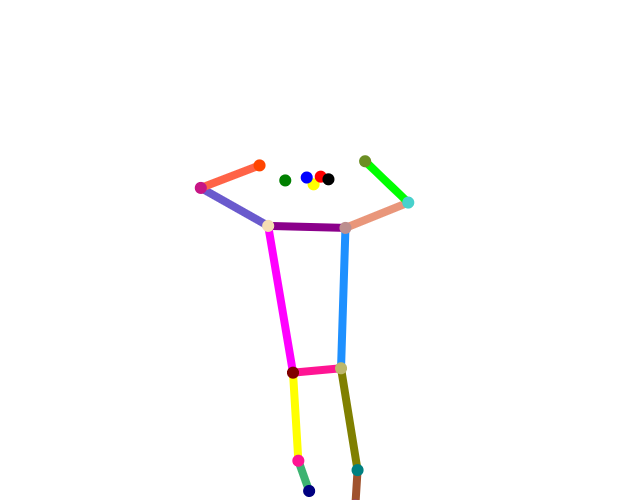

file: training_data/images/dramatic_548.png


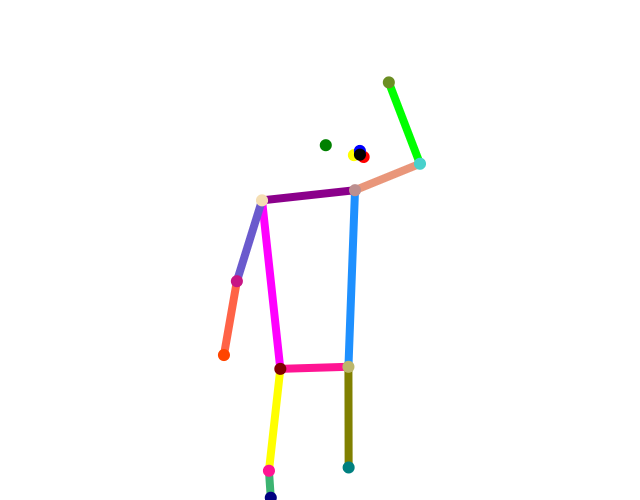

file: training_data/images/underarm_67.png


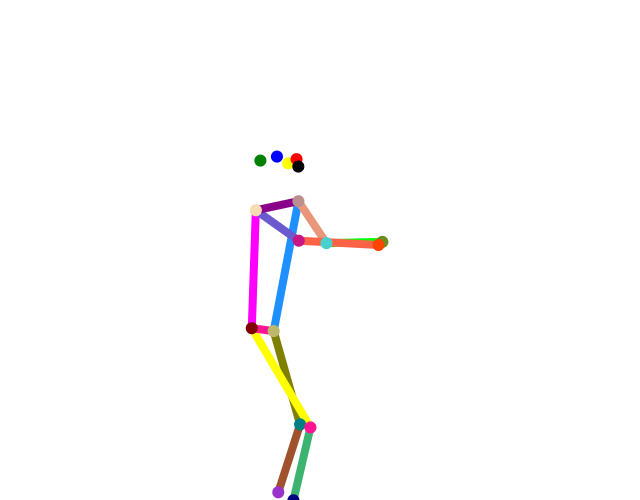

file: training_data/images/radouken_88.png


In [38]:
import IPython.display as display
import math
import matplotlib.pyplot as plt

# lets check our images to see what they look like
for n in range(3):  
    image = random.choice(all_image_paths)
    display.display(display.Image(str(image)))
    print(f"file: {image}")


In [39]:
# get unique classes
huia_person=[]
for label in all_image_labels:
    if label not in huia_person:
        huia_person.append(label)
huia_person = sorted(huia_person) # sort label list
huia_person

['backpack',
 'dramatic',
 'fly',
 'moonwalk',
 'normal',
 'radouken',
 'underarm',
 'wings']

In [40]:
label_to_index = dict((name, index) for index,name in enumerate(huia_person))
label_to_index

{'backpack': 0,
 'dramatic': 1,
 'fly': 2,
 'moonwalk': 3,
 'normal': 4,
 'radouken': 5,
 'underarm': 6,
 'wings': 7}

In [41]:
# lets format it, so we can copy and paste the dict into javascript :-)
print("POSE_CLASSES = {")
for index,name in enumerate(huia_person):
    print(str(index)+": '"+name+"',")
print("}")

POSE_CLASSES = {
0: 'backpack',
1: 'dramatic',
2: 'fly',
3: 'moonwalk',
4: 'normal',
5: 'radouken',
6: 'underarm',
7: 'wings',
}


(500, 640, 4)
<dtype: 'uint8'>


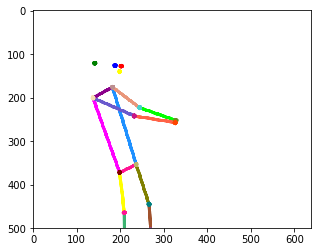

In [42]:
# load data into tf data
img_raw = tf.io.read_file(all_image_paths[1])
img_tensor = tf.image.decode_image(img_raw)
print(img_tensor.shape)
print(img_tensor.dtype)
plt.imshow(img_tensor)

In [43]:
from random import randint

# resize + normalize + data augmentation
def preprocess_image(image):
    # resize
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    # random flip - doesn make sense in our case
    # image = tf.image.random_flip_left_right(image)
    # random rotate
    degree_angle = random.randint(-2,2)
    radian = degree_angle * math.pi / 180
    #image = tfa.image.rotate(image,radian) #,interpolation='BILINEAR')
    # normalize
    offset = 127.5;
    image = (image-offset)/offset  # convert to -1 : 1    
    return image

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

#def train_preproccess(image,label):
    #image = tf.image.random_crop(image,[224,224,3])
    #image = tf.image.random_flip_left_right(image)
    #image = tf.keras.preprocessing.image.random_rotation(image,15)
    #image = tf.keras.preprocessing.image.random_zoom(image, 20)

In [44]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
path_ds

<TensorSliceDataset shapes: (), types: tf.string>

In [45]:
image_ds = path_ds.map(load_and_preprocess_image,num_parallel_calls = AUTOTUNE)
image_ds

<ParallelMapDataset shapes: (224, 224, 3), types: tf.float32>

W0428 00:18:53.650682 139657742489408 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


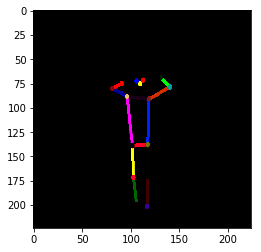

In [46]:
#!pip install Pillow
import matplotlib.pyplot as plt
from PIL import Image


## rotate images
# https://stackoverflow.com/questions/53273226/how-to-rotate-images-at-different-angles-randomly-in-tensorflow

for image in image_ds:
    #print(image)
    #print(type(image))
    #print(image.shape)
    #print(image.numpy().max())
    #im = image.numpy()
    #im=im[:,:,0]
    #print(im.shape)
    #im = Image.fromarray(image.numpy(), 'RGB')
    #im = tf.image.encode_png(im)
    #im = tf.image.convert_image_dtype(image,tf.float32)
    #print(im.max())
    #display.display(display.Image(image))
    #im.show()
    plt.imshow(image)
    break

In [47]:
all_image_labels_idx = [label_to_index[label] for label in all_image_labels]
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels_idx, tf.int64))

In [48]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
image_label_ds
image_count = len(all_image_labels)

type(image_label_ds)

tensorflow.python.data.ops.dataset_ops.ZipDataset

In [49]:
BATCH_SIZE = 32

ds = image_label_ds.cache()
ds = ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
ds

W0428 00:18:58.944280 139657742489408 deprecation.py:323] From <ipython-input-49-b40e28647b1f>:4: shuffle_and_repeat (from tensorflow.python.data.experimental.ops.shuffle_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [50]:
# we will use a pretrained mobilenet for transferlearning
mobilenet = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),include_top=False,weights='imagenet')
mobilenet.trainable = False
mobilenet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [51]:
image_batch, label_batch = next(iter(ds))
print(image_batch.shape)
#image_batch[0]

(32, 224, 224, 3)


In [52]:
#label_batch[0].numpy()
#image_batch[0].numpy()

In [53]:
feature_map_batch = mobilenet(image_batch)
print(feature_map_batch.shape)

(32, 7, 7, 1280)


In [54]:
model = tf.keras.Sequential([
    mobilenet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1024,activation='relu',bias_initializer=tf.keras.initializers.he_normal()),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1024,activation='relu',bias_initializer=tf.keras.initializers.he_normal()),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512,activation='relu',bias_initializer=tf.keras.initializers.he_normal(),name='features'),
    tf.keras.layers.Dense(len(huia_person),activation='softmax'),
])
#model.summary()
mobilenet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [55]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: 0.055229105
max logit: 0.30435076

Shape: (32, 8)


In [56]:
len(model.trainable_variables) 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0

In [57]:
steps_per_epoch=tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

11.0

In [58]:
# class myCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs={}):
#     if(logs.get('val_accuracy')>0.9):
#       print("\nReached 60% accuracy so cancelling training!")
#       self.model.stop_training = True

callbacks = []

#tbCallback = tf.keras.callbacks.TensorBoard(log_dir='./logs',histogram_freq=1,  embeddings_freq=1)
#tbCallback.set_model(model)
#callbacks.append(tbCallback)

# earlyStopping = tf.keras.callbacks.EarlyStopping(patience=2, monitor='loss')
# callbacks.append(earlyStopping)

chkPoint = tf.keras.callbacks.ModelCheckpoint('./models.h5')
chkPoint.set_model(model)
callbacks.append(chkPoint)


In [59]:
#ds.shuffle(buffer_size=32)
test_dataset = ds.take(70) 
train_dataset = ds.skip(70)

In [65]:
mobilenet.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(lr=3e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-07, amsgrad=False), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [66]:
model.fit(train_dataset, epochs=100,steps_per_epoch=steps_per_epoch,verbose=1,validation_data=test_dataset,
          callbacks=callbacks)

Epoch 1/100
11/11 [==============================] - 43s 4s/step - loss: 8.6696e-04 - accuracy: 1.0000 - val_loss: 3.7804 - val_accuracy: 0.7386
Epoch 2/100
11/11 [==============================] - 3s 237ms/step - loss: 0.0029 - accuracy: 0.9972 - val_loss: 3.6515 - val_accuracy: 0.7386
Epoch 3/100
11/11 [==============================] - 3s 243ms/step - loss: 6.7511e-05 - accuracy: 1.0000 - val_loss: 3.4937 - val_accuracy: 0.7386
Epoch 4/100
11/11 [==============================] - 3s 239ms/step - loss: 4.2605e-04 - accuracy: 1.0000 - val_loss: 3.2398 - val_accuracy: 0.7415
Epoch 5/100
11/11 [==============================] - 3s 244ms/step - loss: 4.3667e-04 - accuracy: 1.0000 - val_loss: 2.9660 - val_accuracy: 0.7443
Epoch 6/100
11/11 [==============================] - 3s 239ms/step - loss: 4.8773e-05 - accuracy: 1.0000 - val_loss: 2.7574 - val_accuracy: 0.7557
Epoch 7/100
11/11 [==============================] - 3s 237ms/step - loss: 9.0393e-04 - accuracy: 1.0000 - val_loss: 2.6158 

Epoch 57/100
11/11 [==============================] - 3s 243ms/step - loss: 5.6713e-05 - accuracy: 1.0000 - val_loss: 0.0324 - val_accuracy: 0.9915
Epoch 58/100
11/11 [==============================] - 3s 247ms/step - loss: 4.9295e-05 - accuracy: 1.0000 - val_loss: 0.0310 - val_accuracy: 0.9915
Epoch 59/100
11/11 [==============================] - 3s 242ms/step - loss: 4.9514e-05 - accuracy: 1.0000 - val_loss: 0.0297 - val_accuracy: 0.9915
Epoch 60/100
11/11 [==============================] - 3s 246ms/step - loss: 1.4864e-05 - accuracy: 1.0000 - val_loss: 0.0286 - val_accuracy: 0.9943
Epoch 61/100
11/11 [==============================] - 3s 247ms/step - loss: 5.5193e-05 - accuracy: 1.0000 - val_loss: 0.0277 - val_accuracy: 0.9943
Epoch 62/100
11/11 [==============================] - 3s 242ms/step - loss: 1.1451e-05 - accuracy: 1.0000 - val_loss: 0.0269 - val_accuracy: 0.9943
Epoch 63/100
11/11 [==============================] - 3s 245ms/step - loss: 3.1744e-05 - accuracy: 1.0000 - val_

In [67]:
model.save("models/huia_mob_224_teste_2.h5") # .9972

In [68]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, "models_tfjs/tfjs_huia_mob_224_teste_2_q",quantization_dtype=np.uint16)

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model,'model.png',show_layer_names=False) #,show_shapes=True)

In [ ]:
%load_ext tensorboard.notebook

#notebook.list() # View open TensorBoard instances
#notebook.display(port=6006, height=1000)

In [ ]:
#!kill 25264
%tensorboard --logdir ./logs

In [ ]:
import time
default_timeit_steps = 2*steps_per_epoch+1

def timeit(ds, steps=default_timeit_steps):
  overall_start = time.time()
  # Fetch a single batch to prime the pipeline (fill the shuffle buffer),
  # before starting the timer
  it = iter(ds.take(steps+1))
  next(it)

  start = time.time()
  for i,(images,labels) in enumerate(it):
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))
  print("Total time: {}s".format(end-overall_start))

In [ ]:
timeit(ds)

# Predict

In [12]:
import numpy as np
sample = np.reshape(img_final,[1,224,224,3])

predict = int(model.predict_classes(sample))
predict

NameError: name 'img_final' is not defined

In [ ]:
[key for key,value in label_to_index.items() if value == predict]

In [ ]:
label_to_index